## Partial Dependence Plotを用いた結果の解釈

In [1]:
%matplotlib inline
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from pdpbox import pdp, get_dataset, info_plots


In [2]:
df_date_data = pd.read_csv('../../data/day.csv', header=0)
df_date_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
#今回使用するカラムに限定
used_columns = ['cnt', 'season', 'yr', 'mnth', 'holiday', 'weathersit', 'temp', 'hum', 'windspeed']
df = df_date_data.loc[:,used_columns]
df.head()

,cnt,season,yr,mnth,holiday,weathersit,temp,hum,windspeed
0,985,1,0,1,0,2,0.344167,0.805833,0.160446
1,801,1,0,1,0,2,0.363478,0.696087,0.248539
2,1349,1,0,1,0,1,0.196364,0.437273,0.248309
3,1562,1,0,1,0,1,0.200000,0.590435,0.160296
4,1600,1,0,1,0,1,0.226957,0.436957,0.186900


In [4]:
# 特定のカラムに関して、ダミー変数を作成する
# pdpboxを使用する場合One-Hot Encodingは必須

ohe_columns = ['season', 'mnth', 'weathersit']
df_ohe = pd.get_dummies(df, columns=ohe_columns)

In [5]:
X = df_ohe.iloc[:, 1:]
y = df_ohe.iloc[:, 0]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

X.head()

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,mnth_1,...,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,weathersit_1,weathersit_2,weathersit_3
0,0,0,0.344167,0.805833,0.160446,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0.363478,0.696087,0.248539,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0.196364,0.437273,0.248309,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0.200000,0.590435,0.160296,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0.226957,0.436957,0.186900,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# 通常通り学習&精度評価
rf_model = RandomForestRegressor(n_estimators=100,random_state=50)
rf_model.fit(train_X, train_y)

pred_y = rf_model.predict(test_X)
score = sqrt(mean_squared_error(test_y, pred_y))

print('RMSE: {}'.format(score))

RMSE: 709.449339870619


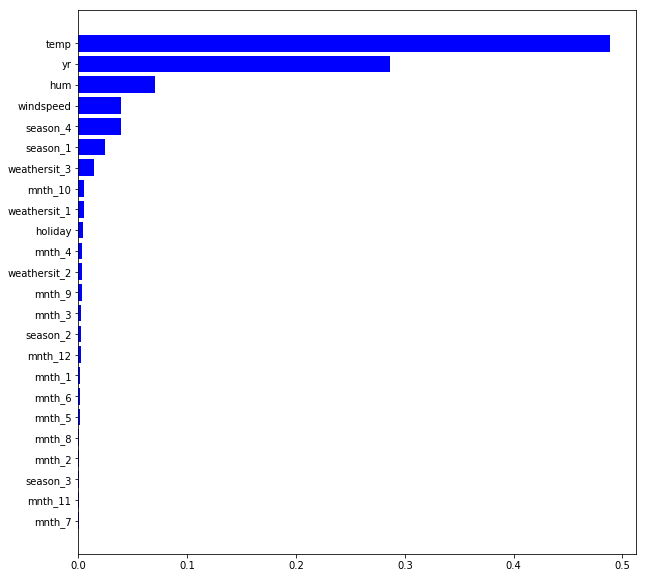

In [7]:
# feature importance
# tempの影響度がかなり大きい。今回はtempに注目する
features = df_ohe.columns[1:]
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,10))
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

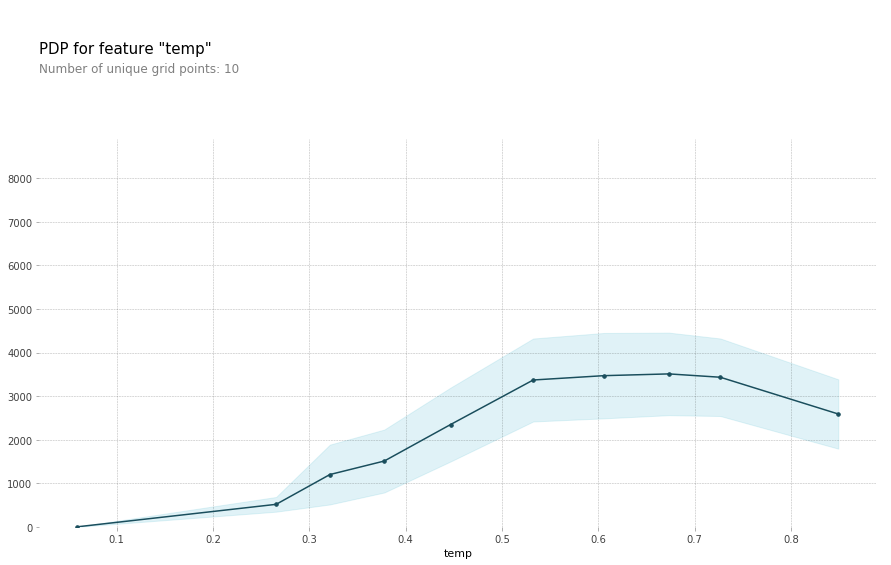

In [8]:
# Partial Dependence Plot
features = train_X.columns.values
feature_to_plot = 'temp'
pdp_goals = pdp.pdp_isolate(model=rf_model, dataset=train_X[features], model_features=list(features), feature=feature_to_plot)

# PDPの実行
# データ自体が元から正規化されているためここでは具体的な値がわからないが傾向はつかめる
pdp.pdp_plot(pdp_goals, feature_to_plot)
plt.show()

このプロットを見たところtemp>0.25より大きいところで伸び幅が増加。   
その後は線形に増加していくわけではなくtemp>0.72付近から減少傾向にある。

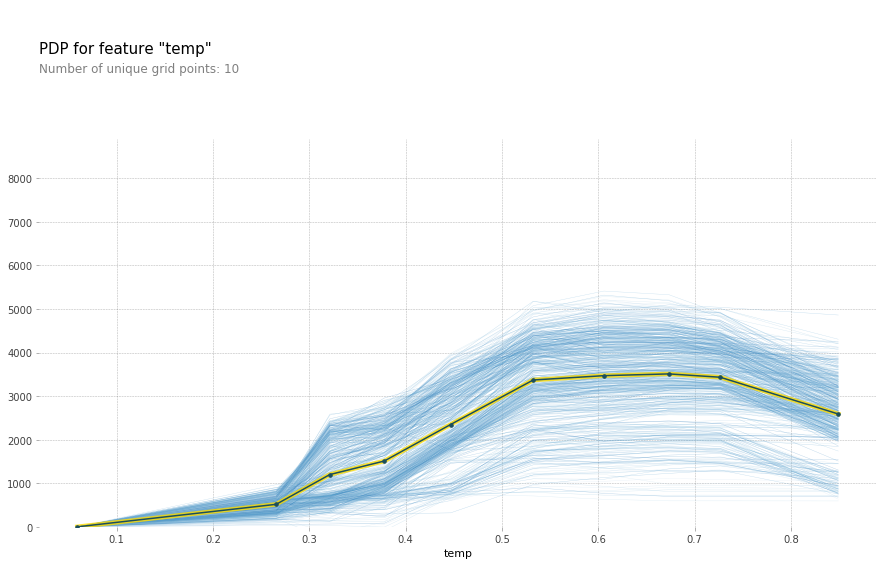

In [9]:
# Individual Conditional Expectation
pdp.pdp_plot(pdp_goals, feature_to_plot, plot_lines=True)
plt.show()

0.25<temp<0.5付近まで上限と下限の差が比較的大きい。 

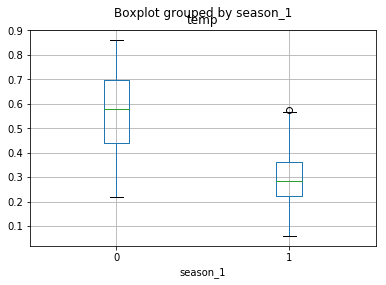

In [10]:
# tempは季節と一定の相関があるため考慮が必要
df_ohe.boxplot('temp', by='season_1')

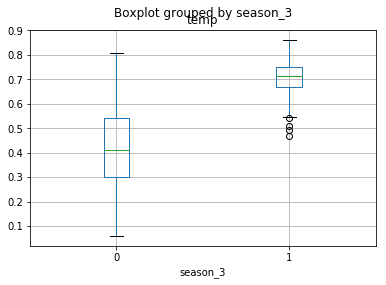

In [11]:
df_ohe.boxplot('temp', by='season_3')